# DTSA 5511 NLP Mini Project

## Project Overview

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). However, it’s not always clear whether a person’s words are actually announcing a disaster. This project utilizes deep learning techniques to predict which Tweets are about real disasters and which one’s aren’t.

In [10]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import re
import nltk  
nltk.download('stopwords') 
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer 
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/colincunningham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1: Collect Data

The data used in this project was taken from Kaggle (https://www.kaggle.com/c/nlp-getting-started/data) and contains textual data from real tweets. In total, the training data contains 7,613 rows and 5 columns:

id: unique identifier

keyword: keyword from tweet (can be null)

location: location tweet was sent from (can be null)

text: raw text from tweet

target: 1 if real disaster, 0 if not

The test data contains 3,263 observations and all of the columns mentioned above excluding the target variable.

In [2]:
# read training data with labels
train_df = pd.read_csv("/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/nlp-getting-started/train.csv")
test_df = pd.read_csv("/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/nlp-getting-started/test.csv")

## Step 2: Exploratory Data Analysis (EDA)

Below, I conducted some initial exploratory analysis to familiarize myself with the dataset. As you can see the training dataframe contains 7,613 rows and 5 columns (listed above) and the test data contains 3,263 observations.

In [3]:
# print training data
print('Print first 5 rows of training data:')
print(train_df.head())

print('\nDF info:')
train_df.info()

Print first 5 rows of training data:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.

In [4]:
# print test data
print('Print first 5 rows of test data:')
print(test_df.head())

print('\nDF info:')
test_df.info()

Print first 5 rows of test data:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan

DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


### Data Visualization

In the cell below, I visualized the number of observations belonging to each class (disaster vs. no disaster). As you can see, the dataset is relatively balanced though there are more instances belonging to the "disaster" class. Before constructing our models, we will need to employ sampling techniques so that the model isn't biased towards the majority class.

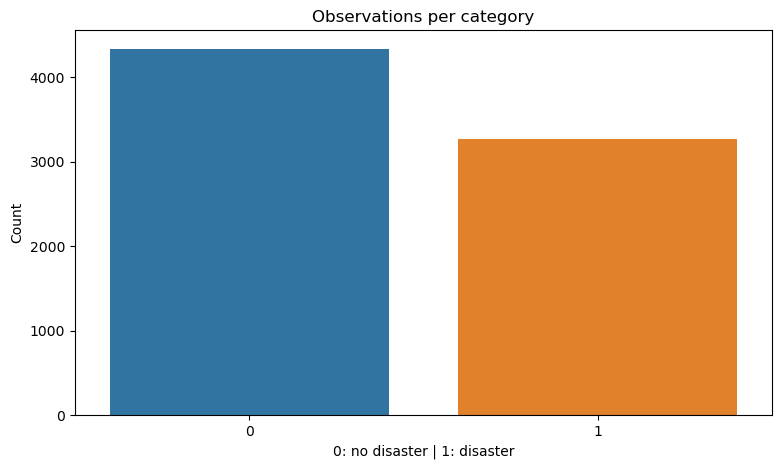

In [5]:
# create bar chart with observation counts
plt.figure(figsize = (9,5))
plt.title('Observations per category')
gb = train_df.groupby('target').size().reset_index()
ax = sns.barplot(x='target', data=gb, y = 0, linewidth=2).set(ylabel="Count", xlabel = '0: no disaster | 1: disaster')
plt.show()

In this next cell, I created a wordcloud containing the most common words in the text column of the training dataframe. As you can see, there are many words (fire, emergency, crash, etc.) that you would expect to read in a tweet about a disaster, though there are also words that don't indicate a disaster.

(-0.5, 4999.5, 3999.5, -0.5)

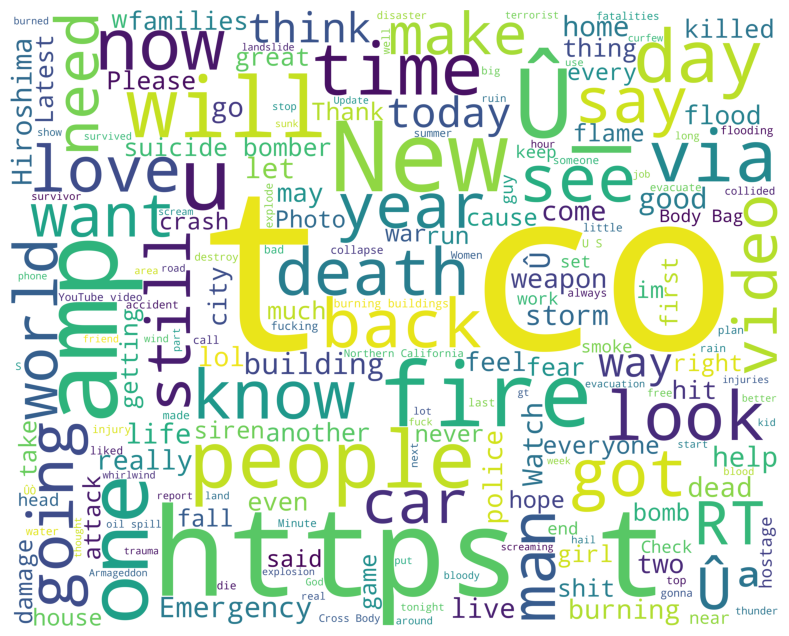

In [6]:
# set stopwords
stopwords = set(STOPWORDS)

# get individual words in text column
text = " ".join(i for i in train_df.text)

# create wordcloud
wordcloud = WordCloud(width = 5000, 
                          height = 4000,
                          background_color = 'white',
                          stopwords = stopwords,
                          min_font_size = 10).generate(text)

# display wordcloud
plt.figure(figsize=(12, 8))    
plt.imshow(wordcloud)
plt.axis('off')

### Data Cleaning

In the cell below, I defined a function to clean the raw text data. The function clean_text takes a string of raw text as input and returns a "clean" version in a uniform format without the stopwords and.

In [11]:
# define function to clean raw text data
def clean_text(text):
    
    # remove characters not in alphabet
    text = re.sub('[^a-zA-Z]', '', text)  
    
    # convert text to lowercase
    text = text.lower()  
    
    # create list of individual words
    text = text.split()  
    
    # remove stopwords from list
    text = [word for word in text if not word in set(stopwords.words('english'))] 
    
    # join words back together
    text = ' '.join(text)    
            
    return text

In [12]:
# clean raw text for both train/test data
train_df['text'] = train_df['text'].apply(lambda x : clean_text(x))
test_df['text'] = test_df['text'].apply(lambda x : clean_text(x))

## Step 3: Model Architecture

#### Recurrent Neural Networks (RNNs)
Recurrent Neural Networks are designed to capture sequential dependencies, making them suitable for NLP tasks where word order is important, such as text classification. However, RNNs process data sequentially which results in much slower training times. Though RNNs have been used for these types of tasks in the past, there are more cutting-edge architectures that are worth exploring.

#### Convolutional Neural Networks (CNN)
Convolutional Neural Netowrks are traditionally used for computer vision, but they have been adapted for NLP tasks by treating text as an image. CNNs are effective at capturing local patterns and features in sequences, making them suitable for tasks where local word arrangements are important. Furthermore, they can process data sequences in paralell which allows for computationally efficient training.

#### Long Short-Term Memory (LSTM)
LSTMs were created to address the vanishing gradient problem that plagues earlier neural networks such as RNNs and CNNs. The vanishing gradient problem is a phenomenon that occurs when training neural networks and prevents the model from being able to capture long-term dependencies in the data. LSTMs can capture information from earlier sequences and retain it for an extended period, making them effective for solving NLP related tasks.

#### My Selection
The short list above contains a handful of deep learning architectures that are commonly used for text classification, though there are many others. I chose the LSTM model for my Kaggle submission because it has a higher F1 score, which is the evaluation metric for this project.

## Step 4: Results & Analysis

### Data Preprocessing

Before constructing our models, we had to tokenize the raw text data so that it could be used as an input. I used Tensorflow's Tokenizer function to split the raw text into individual words and the texts_to_sequences function to vectorize the tokens. Then, I used Sklearn's train_test_split function (with 80/20 split) to separate the data into training and validation sets.

In [13]:
# tokenize raw data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['text'])
sequences = tokenizer.texts_to_sequences(train_df['text'])
X = pad_sequences(sequences, maxlen=100)

# convert labels to numerical format
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['target'])

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

### Model Construction

In the subsequent cells, I constructed 2 deep learning models with with different architectures.

In [14]:
# build model 1
mod1 = Sequential()

# add layers to model 1
mod1.add(Embedding(input_dim=10000, output_dim=50, input_length=100))
mod1.add(Conv1D(128, 5, activation='relu'))
mod1.add(GlobalMaxPooling1D())
mod1.add(Dense(128, activation='relu'))
mod1.add(Dense(1, activation='sigmoid'))

# compile model 1
mod1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# print model summary
mod1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 548769 (2.09 MB)
Trainable params: 548769 (2.09 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [15]:
# fit model 1
hist1 = mod1.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
96/96 [==============================] - 1s 9ms/step - loss: 0.6838 - accuracy: 0.5688 - val_loss: 0.6842 - val_accuracy: 0.5686
Epoch 2/10
96/96 [==============================] - 1s 8ms/step - loss: 0.5719 - accuracy: 0.6821 - val_loss: 0.9241 - val_accuracy: 0.4780
Epoch 3/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0360 - accuracy: 0.9934 - val_loss: 1.1180 - val_accuracy: 0.5515
Epoch 4/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0149 - accuracy: 0.9961 - val_loss: 1.3633 - val_accuracy: 0.5535
Epoch 5/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0169 - accuracy: 0.9944 - val_loss: 1.0042 - val_accuracy: 0.5200
Epoch 6/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 1.5161 - val_accuracy: 0.4498
Epoch 7/10
96/96 [==============================] - 1s 8ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 1.1091 - val_accuracy: 0.4859
Epoch 8/10
96/96 [==

In [16]:
# build model 2
mod2 = Sequential()

# add layers to model 2
mod2.add(Embedding(input_dim=10000, output_dim=50, input_length=100))
mod2.add(LSTM(100))
mod2.add(Dense(64, activation='relu'))
mod2.add(Dense(1, activation='sigmoid'))

# compile model 2
mod2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# print model summary
mod2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           500000    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 566929 (2.16 MB)
Trainable params: 566929 (2.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# fit model 2
hist2 = mod2.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
96/96 [==============================] - 6s 57ms/step - loss: 0.6845 - accuracy: 0.5701 - val_loss: 0.6842 - val_accuracy: 0.5686
Epoch 2/10
96/96 [==============================] - 6s 58ms/step - loss: 0.6099 - accuracy: 0.6722 - val_loss: 0.7321 - val_accuracy: 0.4859
Epoch 3/10
96/96 [==============================] - 6s 59ms/step - loss: 0.0449 - accuracy: 0.9952 - val_loss: 0.9086 - val_accuracy: 0.5115
Epoch 4/10
96/96 [==============================] - 6s 59ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.8970 - val_accuracy: 0.4931
Epoch 5/10
96/96 [==============================] - 6s 60ms/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.8939 - val_accuracy: 0.5213
Epoch 6/10
96/96 [==============================] - 6s 58ms/step - loss: 0.0090 - accuracy: 0.9966 - val_loss: 1.3346 - val_accuracy: 0.5739
Epoch 7/10
96/96 [==============================] - 6s 61ms/step - loss: 0.0109 - accuracy: 0.9959 - val_loss: 0.9287 - val_accuracy: 0.4767
Epoch 8/10
96

In [18]:
# make predictions using models above
pred1 = (mod1.predict(X_test) > 0.5).astype("int32")
pred2 = (mod2.predict(X_test) > 0.5).astype("int32")

48/48 [==============================] - 1s 11ms/step


### Model Evaluation

Below I evaluated my models by creating confusion matrices which compare the predicted values to the true validation labels. At first glance, it appears that both models perform well with higher values in the second and fourth quadrants.

In [19]:
# create confusion matrix for model 1
print('\nModel 1 Confusion Matrix:')
cm1 = confusion_matrix(y_test, pred1, labels=np.unique(y_test))
print(cm1)

# create confusion matrix for model 2
print('\nModel 2 Confusion Matrix:')
cm2 = confusion_matrix(y_test, pred2, labels=np.unique(y_test))
print(cm2)


Model 1 Confusion Matrix:
[[414 452]
 [312 345]]

Model 2 Confusion Matrix:
[[224 642]
 [165 492]]


In the cell below, I calculated the respective F1 scores for each of the models. F1 is an evaluation metric that measures a model's accuracy by combining the precision and recall scores making it a more wholistic evaluation metric compared to any of the individual scores (accuracy, precision, recall). Both models score around 0.55 which suggests that improvements can be made to the architecture, hyperparameters, etc. to improve the predictive power. Ultimately, I decided to use the LSTM model for the Kaggle competition due to the slightly higher F1 score.

In [20]:
# calculate F1 for model 1
print('\nCNN F1 Score:')
mod1_f1 = f1_score(y_test, pred1)
print(mod1_f1)

# calculate F1 for model 2
print('\nLSTM F1 Score:')
mod2_f1 = f1_score(y_test, pred2)
print(mod2_f1)


CNN F1 Score:
0.4745529573590096

LSTM F1 Score:
0.5494137353433837


### Kaggle Competition Submission

In the cells below, I predicted values for the unseen test set using the LSTM model. Then, I added the predictions to the submission dataframe and converted it to a csv file for submission.

In [21]:
# tokenize raw unseen text
testing_sequences = tokenizer.texts_to_sequences(test_df['text'])
testing_padded = pad_sequences(testing_sequences, maxlen=100)

# make predictions on test data
fnl_preds = mod2.predict(testing_padded)

102/102 [==============================] - 1s 13ms/step


In [23]:
# load sample submission
kagg_df = pd.read_csv('/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/nlp-getting-started/sample_submission.csv')

# add predictions to submission df
kagg_df['target'] = (fnl_preds > 0.5).astype(int)

# convert df to csv 
kagg_df.to_csv("nlp_submission.csv", index=False, header=True)

## Step 5: Conclusion

In conclusion, both models performed in a similar fashion, with tbe LSTM model slightly edging out the CNN in terms of the F1 score. While the models perform well, there is room for potential enhancements. A further analysis could explore more complex architectures, ensemble methods, and/or different hyperparameters to improve the performance.

Additionally, I believe that there are other evaluation metrics such as Recall that should be considered before deploying a predictive model in this setting. Recall, which measures the proportion of actual positives should also be considered due to the consequences of not capturing a disaster in real time. If not properly identified, these disasters can lead to the loss of human life and therefore should be considered before deploying a model in a production setting.

## Github Repository

Visit this link to see the full Github repository:
https://github.com/colincunningham-cu/dtsa_5511_nlp_miniproject